In [2]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, Activation, Conv2DTranspose, Concatenate, Input, BatchNormalization
from keras.models import Sequential, Model
from keras.initializers import RandomNormal

## Base data set

In [3]:
#Make the dataset
from cycleganstyletransfer.config import DATA_DIR
data_dir = DATA_DIR / "raw"


my_monet_ds_train, my_monet_ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Monet",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size = 1,
    labels = None,
)

my_image_ds_train, my_image_ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Images",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size = 1,
    labels = None,
)

DATASET_HEIGHT = max(len(my_monet_ds_train), len(my_image_ds_train))

my_monet_ds_train = iter(my_monet_ds_train.shuffle(42).repeat())
my_image_ds_train = iter(my_image_ds_train.shuffle(42).repeat())

2025-06-08 09:52:34.726 | INFO     | cycleganstyletransfer.config:<module>:11 - PROJ_ROOT path is: C:\Users\willi\Desktop\AIPortfolio\CycleGanV2\cycleganstyletransfer


Found 1193 files belonging to 1 classes.
Using 955 files for training.
Using 238 files for validation.
Found 7037 files belonging to 1 classes.
Using 5630 files for training.
Using 1407 files for validation.


## Basic model definition

In [4]:
def DownSampleBlock(filters:int, kernel_size:int, strides:int):
    ret_block = Sequential()
    ret_block.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same'))
    ret_block.add(Activation('relu'))
    return ret_block


In [24]:
import uuid

def UpSampleBlock(filters:int, kernel_size:int, strides:int):
    ret_block = Sequential(name=f'UpsampleBlock_{uuid.uuid4()}')
    ret_block.add(Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same'))
    ret_block.add(Activation('relu'))
    return ret_block

In [25]:

def Generator(input_shape:tuple, kernel_size:int=3, strides:int=1
              ,filter_line:list[int]=[64,128,256]) -> keras.Model:
    networks_appending = []
    input_block = Input(shape=input_shape)
    ret_block = input_block

    #Create encoder chain
    for filter_choice in filter_line:
        ret_block=DownSampleBlock(filter_choice,3,2)(ret_block)
        networks_appending.append(ret_block)

    #Decoder with residual connections
    for filter_choice, network_append in zip(filter_line[::-1][1:], networks_appending[::-1][1:]):
        ret_block = UpSampleBlock(filter_choice, 3,2)(ret_block)
        ret_block = Concatenate()([ret_block, network_append])
    
    ret_block = Conv2DTranspose(input_shape[-1], kernel_size, strides, padding='same', activation='tanh')(ret_block)

    return Model(input_block, ret_block)



In [26]:
my_generator = Generator((128, 128, 3), strides=2)
my_generator.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential_34 (Sequential)  (None, 64, 64, 64)           1792      ['input_9[0][0]']             
                                                                                                  
 sequential_35 (Sequential)  (None, 32, 32, 128)          73856     ['sequential_34[0][0]']       
                                                                                                  
 sequential_36 (Sequential)  (None, 16, 16, 256)          295168    ['sequential_35[0][0]']       
                                                                                            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11533719..0.19360556].


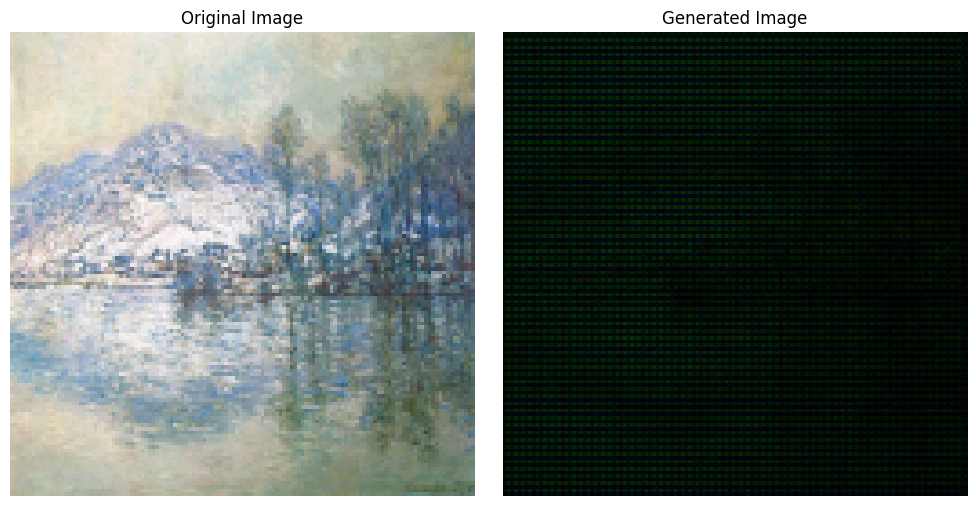

In [28]:
eg_image = next(my_monet_ds_train)
eg_image = eg_image / 255.0  # Normalize to [0, 1] range


import matplotlib.pyplot as plt

# Display original and generated images side by side
plt.figure(figsize=(10,5))

# Original image
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(eg_image[0])
plt.axis('off')

# Generated image
generated_image = my_generator(eg_image)
plt.subplot(1,2,2) 
plt.title('Generated Image')
plt.imshow(generated_image[0])
plt.axis('off')

plt.tight_layout()
plt.show()


##